# BS Optimization

- Solving a constrained resource allocation problem using a sample Bank balance sheet and (mostly) realistic balance sheet constraints

### Background

Bank resource management has become significantly more complex in the last decade. After the 2008 financial crisis, a slew of new regulatory frameworks were enacted, complicating balance sheet management. It was no longer immediately obvious which products were more profitable or what the optimal balance sheet mix was for a given "type" of bank (i.e., Universal vs. Investment vs. Retail bank, etc).

This is where optimization can help. These constraints can be expressed as equations, and by creating bounds on the Balance Sheet (abbreviated here on out as B/S) line items, these equations can be solved in a way that maximizes the profitability of the balance sheet.

### Balance Sheet Overview

Sample data can be found here: https://github.com/marvelje/bs_optimization/tree/main/data

- For purposes of this analysis, I've created a fake bank balance sheet of ~40 line items. I've relied on my experience at a big bank to construct a reasonably realistic scenario for a "universal" bank (i.e., a bank offering a full suite of banking services across retail, commercial, and markets). Many of these line items will look familiar to anyone who's worked in finance. You'll notice auto loans, various types of mortgage products, commercial lending, markets, and a whole suite of deposit products.
- For any optimization to have meaningful results, the line items should be broken down in a way where the bundled products have similar levels of profitability and "resource footprints" (more on this last bit under the Constraints Overview). The more aggregated the data, the less useful it becomes. Therefore, I've broken down a given product category where a subgroup has meaningfully different characteristics. For example, I broke Auto lending down between "Prime" and "Subprime" since the returns and resource footprint is materially different.
- I then created spreads (profitability expressed in basis points, or bps), along with upper and lower bounds. I.e., how much will I allow the products to grow and shrink during the optimization.
- To start, I generated somewhat arbitrary numbers, ensuring only that Assets = Liabilities and the constraints are currently satisfied

### Constraint overview

- This analysis presents a simplified version of the variety of constraints that a large bank currently faces
- Risk weighted assets:
    - This framework attemnpts to turn a given balance into a Risk Weight equivalent. For example, a mortgage loan may have a Standardized RWA of 50%. This means that a 100 dollar mortgage will generate Standardized RWA of 50.
    - The regulation states that the bank must have equity equal to a fixed % of it's Risk Weighted Assets. This is the crux of the give and take of the optimization. Equity is expensive! The bank would prefer not to hold more equity than it needs to so understanding the trade-offs here is important.
    - There are two RWA frameworks: Advanced and Standardized. A given product may have two different weights across each of these frameworks
- GSIB:
    - This is not a standalone constraint, but rather adds to the RWA minimums described above.
    - For example, the RWA minimum may be 8% plus a GSIB surchage, let's say 3%. The GSIB surcharge scales up or down with changes to the balance sheet, with some products contributing more to the GSIB surcharge than others.
    - In reality, this is a "stair-step" framework. The GSIB surcharge moves in increments of 0.5% A given score may place you in the 3% "bucket" until you hit the subsequent threshold, bumping you up to 3.5%. To keep this a linear problem, I removed this stair step and interpolated the GSIB contribution. In othe words, a small increase in balances may make the surcharge 3.05%, when in reality we would've stayed in the 3% bucket. This is the correct approach under a linear framework, although this could be reframed as a non-linear problem to account for this 
- Leverage:
    - This works similarly, but is a bit more straightforward. For example, the leverage requirement for CET1 states that you must have enough Equity to cover at least a fied % of the total assets. Functions similarly as RWA, but there's no intermediate step of 
    
The TLAC stack:
- Each RWA constraint has four components: CET1, T1, Total Capital, and TLAC. Collectively, these comprise the "resource stack". Different resource can contribute to meeting the minimum requirements for each of the levels. And they are additive. For example, the CET1 requirement might be 11% of RWA and this can only be met through equity. T1 minimum might be 13% but can be met with either Equity or Preferred Equity. Total Capital may be 15%, but subordinated debt can be used, etc. Equity is the most expense resource so that will not be used to meet requirements beyond CET1 if there are other options.
- For Leverage, there are only requirements at the CET1 and T1 level.
- Below is an illustration of the typical bank resource stack

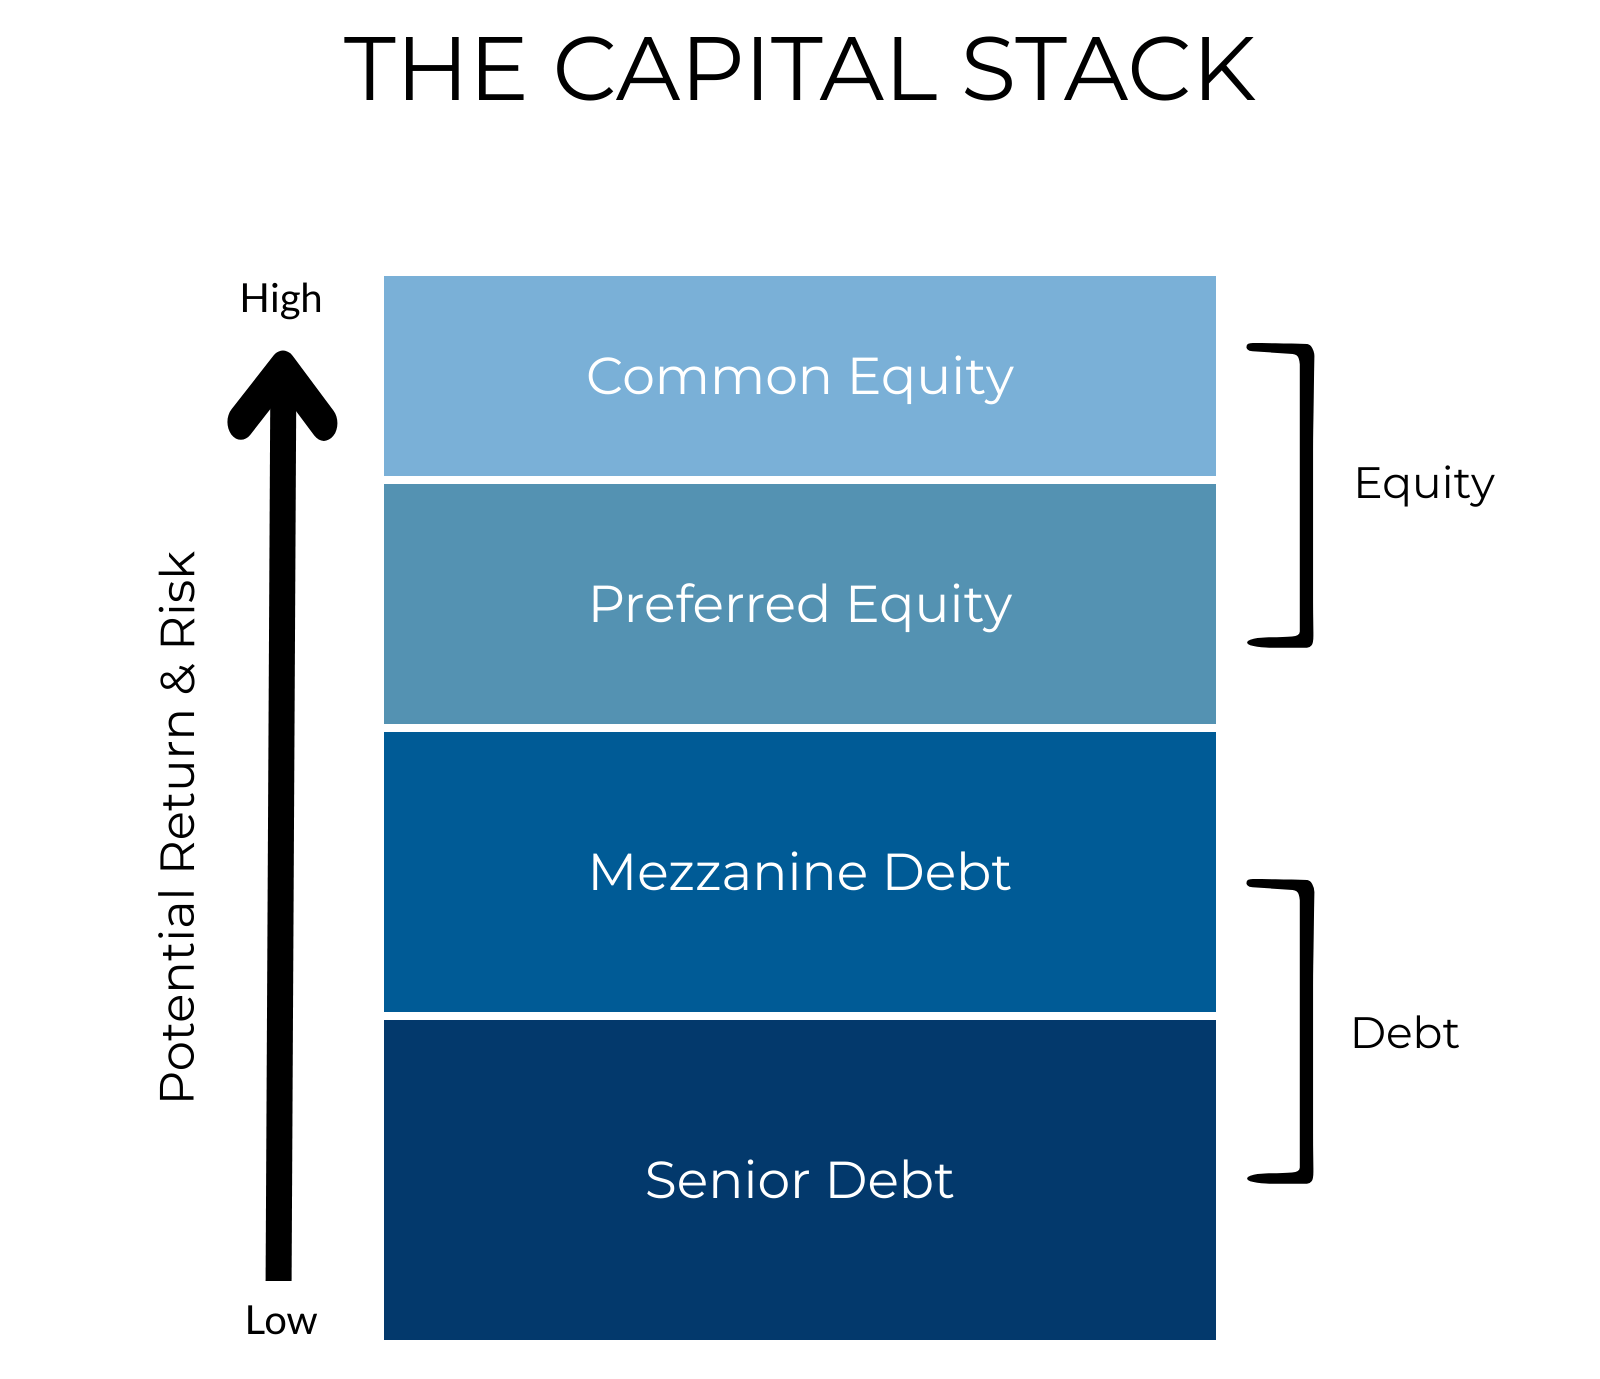

Source: https://www.crowdengine.com/cre-basics-the-capital-stack/

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as spo

In [2]:
# Set options to print all columns of the dataframe
pd.set_option('display.max_columns', None)

# Change float formatting for printing dataframes
pd.options.display.float_format = '{:,.0f}'.format

In [3]:
# Silence SettingWithCopyWarnign
# This isn't the ideal way to solve the problem, but I know I'm getting the behavior I want so I'm just
# Silencing the warning for now
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
# Read in BS data

df = pd.read_excel('./data/sample_bs.xlsx', index_col=0, nrows=40, usecols='A:AO')

In [5]:
df.head()

,Product,start,grow,shrink,spread,A_L,b1_leverage,a_rwa,s_rwa,gsib_leverage,gsib_xjd_claim,gsib_xjd_liab,gsib_intrafin_claim,gsib_intrafin_liab,gsib_securities,gsib_payment,gsib_auc,gsib_underwriting,gsib_otc,`,gsib_level3,CET1_resource,T1_resource,total_capital_resource,TLAC_resource,gsib_leverage_score,gsib_xjd_claim_score,gsib_xjd_liab_score,gsib_intrafin_claim_score,gsib_intrafin_liab_score,gsib_securities_score,gsib_payment_score,gsib_auc_score,gsib_underwriting_score,gsib_otc_score,gsib_trading_score,gsib_level3_score,total_score,cet1_contr,cet1_contr_per_balance
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,prime_auto,15000,8000,-5000,80,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0
2,subprime_auto,4000,2000,-1000,150,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,mtg_30_fixed,50000,30000,-15000,70,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,10,0,0
4,mtg_15_fixed,15000,8000,-3000,72,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0
5,mtg_7_fixed,5000,2500,-2000,70,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [6]:
# Read in constraints

constraints = pd.read_excel('./data/sample_bs.xlsx', index_col=0, sheet_name='constraints')

constraints

,CET1,T1,total_capital,TLAC
SRWA,0,0,0,0
ARWA,0,0,0,0
leverage,0,0,nan,nan
GSIB,0,nan,nan,nan


## Objective function

- This is simply an array of the negative return (i.e., profitability)
- Since the optimization will actually be minimizing this, we just flip the sign

In [7]:
# Define NSI to be passed as part of args

spread = np.array(df['spread'])

In [8]:
def obj_fun(x, spread):
    profitability = 0
    
    for i in range(len(x)):
        profitability += -(spread[i] * x[i])
    
    return profitability

## Starting Guess

In [9]:
# Starting guess is the initial B/S balances
x0 = np.array(df['start'])

## Inequality Constraints

In [10]:
# Extract constraints from the inputs

sRWA_mins = list(constraints.loc['SRWA', :])
aRWA_mins = list(constraints.loc['ARWA', :])
lev_mins = list(constraints.loc['leverage',['CET1', 'T1']])

In [11]:
# Import inequality constraints (see doctstring in separate .py file for description)

from ineq_constraints import srwa_cet1, srwa_t1, srwa_tc, srwa_tlac, arwa_cet1, arwa_t1, arwa_tc, arwa_tlac, \
                             lev_cet1, lev_t1

## Equality Constraint

- Assets must equal liabilities (the actual formula is Assets - Liabilities = 0)

In [12]:
def eq_constraint(x, df=df):
    # Create array of Asset / Liability weights
    a_l_weight = np.array(df['A_L'])
    
    # Define equality target
    eq = 0
    
    for i in range(len(x)):
        eq = eq - x[i] * a_l_weight[i]
    
    return eq

## Consolidate Constraints

Scipy minimize requires each constraint to be a dictionary key value pairs containing the required parameteres. In this case:
- I need to specify whether the constraint is an inequality or equality using the "type" key
- What form the inequality is. In this case the key is "fun" for "function". Then I pass the actual function name (and alternative approach is to use lambda formatting, but given the complexity of my constraints, this is cleaner).
- Any additional args required by the function to calculate the constraints.

In [13]:
con1 = {'type': 'ineq', 'fun': srwa_cet1, 'args': (df, sRWA_mins)}
con2 = {'type': 'ineq', 'fun': srwa_t1, 'args': (df, sRWA_mins)}
con3 = {'type': 'ineq', 'fun': srwa_tc, 'args': (df, sRWA_mins)}
con4 = {'type': 'ineq', 'fun': srwa_tlac, 'args': (df, sRWA_mins)}
con5 = {'type': 'ineq', 'fun': arwa_cet1, 'args': (df, aRWA_mins)}
con6 = {'type': 'ineq', 'fun': arwa_t1, 'args': (df, aRWA_mins)}
con7 = {'type': 'ineq', 'fun': arwa_tc, 'args': (df, aRWA_mins)}
con8 = {'type': 'ineq', 'fun': arwa_tlac, 'args': (df, aRWA_mins)}
con9 = {'type': 'ineq', 'fun': lev_cet1, 'args': (df, lev_mins)}
con10 = {'type': 'ineq', 'fun': lev_t1, 'args': (df, lev_mins)}
con11 = {'type': 'eq', 'fun': eq_constraint}

cons = [con1, con2, con3, con4, con5, con6, con7, con8, con9, con10, con11]

## Upper and Lower Bounds

- These are the bounds that limit the change in balances for each B/S line item
- Bounds are calculated by taking the start balance and adding the allowable grow / shrink capacity

In [14]:
# Create upper and lower bounds. This is the grow and shrink amount for each item

df['u_bound'] = df['start'] + df['grow']
df['l_bound'] = df['start'] + df['shrink']

# Create tuple of lower / upper bounds
df['bounds'] = df.apply(lambda row: tuple((row['l_bound'], row['u_bound'])), axis=1)

# Define bounds in format needed for minimize

bounds = tuple(df['bounds'])

## Minimize

Pass objective function, starting guess, method, bounds, and contraints into the minimization function

In [15]:
# Use trust-const as this is best suited to handle our particular use case

sol = spo.minimize(obj_fun, x0, method = 'trust-constr', bounds=bounds, constraints=cons, args = (spread))

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [16]:
sol.success

True

In [17]:
# Compare profitability increase

-(obj_fun(x0, spread=spread) - sol.fun) / obj_fun(x0, spread=spread)

# The optimal balance sheet has 38% higher profitability

0.3755480149671778

In [27]:
# Save and export results

results = pd.DataFrame(sol.x)
results.to_excel('./results/results.xlsx')

## Analysis

- The next section will take a look at the optimal results
- This is maybe more easily done in Excel

In [28]:
sol.x

array([ 1.00000000e+04,  6.00000000e+03,  8.00000000e+04,  2.30000000e+04,
        7.50000000e+03,  3.00000000e+04,  1.35000000e+04,  8.00000000e+04,
        1.75000000e+04,  3.21667725e+04,  4.65000000e+04,  2.80000000e+04,
        8.50000000e+04,  1.05000000e+05,  7.50000000e+04,  9.50000000e+04,
        3.40000000e+04,  1.30000000e+04,  1.50000000e+03,  1.23769098e-16,
        2.40000000e+05,  8.85000000e+04,  1.10000000e+05,  2.60000000e+04,
        1.20000000e+04,  3.50000000e+03,  7.50000000e+04,  3.20000000e+04,
        2.20000000e+04,  1.25000000e+04,  1.60000000e+04,  9.50000000e+03,
        5.00000000e+03,  2.00000000e+03,  3.00000000e+03, -3.98440647e-17,
        6.31113597e+04,  1.12419837e+04,  7.79662017e+03,  4.35168089e+04])

In [29]:
df.head()

,Product,start,grow,shrink,spread,A_L,b1_leverage,a_rwa,s_rwa,gsib_leverage,gsib_xjd_claim,gsib_xjd_liab,gsib_intrafin_claim,gsib_intrafin_liab,gsib_securities,gsib_payment,gsib_auc,gsib_underwriting,gsib_otc,`,gsib_level3,CET1_resource,T1_resource,total_capital_resource,TLAC_resource,gsib_leverage_score,gsib_xjd_claim_score,gsib_xjd_liab_score,gsib_intrafin_claim_score,gsib_intrafin_liab_score,gsib_securities_score,gsib_payment_score,gsib_auc_score,gsib_underwriting_score,gsib_otc_score,gsib_trading_score,gsib_level3_score,total_score,cet1_contr,cet1_contr_per_balance,u_bound,l_bound,bounds
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,prime_auto,15000,8000,-5000,80,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,23000,10000,"(10000, 23000)"
2,subprime_auto,4000,2000,-1000,150,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6000,3000,"(3000, 6000)"
3,mtg_30_fixed,50000,30000,-15000,70,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,10,0,0,80000,35000,"(35000, 80000)"
4,mtg_15_fixed,15000,8000,-3000,72,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,23000,12000,"(12000, 23000)"
5,mtg_7_fixed,5000,2500,-2000,70,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7500,3000,"(3000, 7500)"


In [30]:
# List of columns required for results table
cols = ['Product', 'start', 'spread', 'A_L', 'b1_leverage', 'a_rwa', 's_rwa', 'cet1_contr_per_balance']

# Filter original DF on these columns in a new "results" object
df_results = df[cols]

# Add in optimal balance
df_results.loc[:,'optimal_balance'] = sol.x
df_results.loc[:,'balance_change'] = df_results.loc[:,'optimal_balance'] - df_results.loc[:,'start']

df_results.head()

,Product,start,spread,A_L,b1_leverage,a_rwa,s_rwa,cet1_contr_per_balance,optimal_balance,balance_change
Index,,,,,,,,,,
1,prime_auto,15000,80,1,1,0,1,0,"10,000","-5,000"
2,subprime_auto,4000,150,1,1,1,1,0,"6,000","2,000"
3,mtg_30_fixed,50000,70,1,1,0,0,0,"80,000","30,000"
4,mtg_15_fixed,15000,72,1,1,0,0,0,"23,000","8,000"
5,mtg_7_fixed,5000,70,1,1,0,0,0,"7,500","2,500"


In [31]:
# Calculate final GSIB surcharge
df_results['GSIB_surcharge'] = df_results['optimal_balance'] * df_results['cet1_contr_per_balance']

gsib_surcharge = df_results['GSIB_surcharge'].sum()

# Calculate final constraint minimums using GSIB surcharge
constraints_final = constraints.copy()

# Add GSIB surcharge to the RWA constraints
constraints_final.loc[['SRWA','ARWA'],:] = constraints_final.loc[['SRWA','ARWA'],:] + gsib_surcharge

constraints_final

,CET1,T1,total_capital,TLAC
SRWA,0,0,0,0
ARWA,0,0,0,0
leverage,0,0,nan,nan
GSIB,0,nan,nan,nan


In [32]:
# Create columns for final constraint amounts

# SRWA
df_results['S_CET1'] = df_results['optimal_balance'] * df_results['s_rwa'] * constraints_final.loc['SRWA', 'CET1']
df_results['S_T1'] = df_results['optimal_balance'] * df_results['s_rwa'] * constraints_final.loc['SRWA', 'T1']
df_results['S_TC'] = df_results['optimal_balance'] * df_results['s_rwa'] * constraints_final.loc['SRWA', 'total_capital']
df_results['S_TLAC'] = df_results['optimal_balance'] * df_results['s_rwa'] * constraints_final.loc['SRWA', 'TLAC']

# ARWA
df_results['A_CET1'] = df_results['optimal_balance'] * df_results['a_rwa'] * constraints_final.loc['ARWA', 'CET1']
df_results['A_T1'] = df_results['optimal_balance'] * df_results['a_rwa'] * constraints_final.loc['ARWA', 'T1']
df_results['A_TC'] = df_results['optimal_balance'] * df_results['a_rwa'] * constraints_final.loc['ARWA', 'total_capital']
df_results['A_TLAC'] = df_results['optimal_balance'] * df_results['a_rwa'] * constraints_final.loc['ARWA', 'TLAC']

# Leverage
df_results['L_CET1'] = df_results['optimal_balance'] * df_results['b1_leverage'] * constraints_final.loc['leverage', 'CET1']
df_results['L_T1'] = df_results['optimal_balance'] * df_results['b1_leverage'] * constraints_final.loc['leverage', 'T1']

In [33]:
df_results[df_results['Product'] == 'equity']['optimal_balance']

Index
37   63,111
Name: optimal_balance, dtype: float64

In [35]:
# Create a dataframe to store "excess capacity" vs the constraints
df_capacity = pd.DataFrame(index=['SRWA', 'ARWA', 'Lev', 'Resources'], columns=['CET1', 'T1', 'TC', 'TLAC'])


# Fill in the resources with the final resource stack quanitites
df_capacity.loc['Resources', 'CET1'] = float(df_results[df_results['Product'] == 'equity']['optimal_balance'])
df_capacity.loc['Resources', 'T1'] = float(df_results[df_results['Product'] == 'prefs']['optimal_balance']) + df_capacity.loc['Resources', 'CET1']
df_capacity.loc['Resources', 'TC'] = float(df_results[df_results['Product'] == 'sub_debt']['optimal_balance']) + df_capacity.loc['Resources', 'T1']
df_capacity.loc['Resources', 'TLAC'] = float(df_results[df_results['Product'] == 'senior_debt']['optimal_balance']) + df_capacity.loc['Resources', 'TC']

In [36]:
pd.options.display.float_format = '{:,.0f}'.format

In [37]:
# Fill in excess vs. constraints

# Standardized RWA. The math is the requirement at each tier of the resource stack - available resources
df_capacity.loc['SRWA', 'CET1'] = df_capacity.loc['Resources', 'CET1'] - df_results['S_CET1'].sum()
df_capacity.loc['SRWA', 'T1'] = df_capacity.loc['Resources', 'T1'] - df_results['S_T1'].sum()
df_capacity.loc['SRWA', 'TC'] = df_capacity.loc['Resources', 'TC'] - df_results['S_TC'].sum()
df_capacity.loc['SRWA', 'TLAC'] = df_capacity.loc['Resources', 'TLAC'] - df_results['S_TLAC'].sum()

# Advanced RWA. Same math as above.
df_capacity.loc['ARWA', 'CET1'] = df_capacity.loc['Resources', 'CET1'] - df_results['A_CET1'].sum()
df_capacity.loc['ARWA', 'T1'] = df_capacity.loc['Resources', 'T1'] - df_results['A_CET1'].sum()
df_capacity.loc['ARWA', 'TC'] = df_capacity.loc['Resources', 'TC'] - df_results['A_CET1'].sum()
df_capacity.loc['ARWA', 'TLAC'] = df_capacity.loc['Resources', 'TLAC'] - df_results['A_CET1'].sum()

# Leverage
df_capacity.loc['Lev', 'CET1'] = df_capacity.loc['Resources', 'CET1'] - df_results['L_CET1'].sum()
df_capacity.loc['Lev', 'T1'] = df_capacity.loc['Resources', 'T1'] - df_results['L_T1'].sum()

# Decided it was a bit more intuitive if the resource stack was the index.
df_capacity = df_capacity.T

In [38]:
df_capacity

,SRWA,ARWA,Lev,Resources
CET1,0,"12,558","4,411","63,111"
T1,"3,083","23,800",0,"74,353"
TC,0,"31,596",NaN,"82,150"
TLAC,0,"75,113",NaN,"125,667"
